In [1]:
import os
from pyspark.sql import SparkSession
from pyspark import  SparkContext
import pandas as pd
import numpy as np
from draw_candle_image import *
import ta.trend
from ta import add_all_ta_features
from ta.utils import dropna
import ta
import ta.momentum
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import tensorflow as tf
import keras
import random
import json

In [2]:
import ta.trend
import ta.volatility

file_csv = './data/vnindex_2000_07_28_to_2024_11_14.csv'
stock_df = pd.read_csv(file_csv)
stock_df["Date"] = pd.to_datetime(stock_df['Date'])
stock_df["Macd"] = ta.trend.macd(stock_df["Close"], fillna=True)
stock_df["Macd_signal"]= ta.trend.macd_signal(stock_df["Close"], fillna=True)
stock_df["Macd_histogram"] = ta.trend.macd_diff(stock_df["Close"], fillna=True)

indicator_bb = ta.volatility.BollingerBands(close=stock_df["Close"], window=20, window_dev=2, fillna=True)
stock_df['BB_avg'] = indicator_bb.bollinger_mavg()
stock_df['BB_high'] = indicator_bb.bollinger_hband()
stock_df['BB_low'] = indicator_bb.bollinger_lband()

indicator_SMA = ta.trend.SMAIndicator(stock_df["Close"], 20, fillna=True)
stock_df["SMA"] = indicator_SMA.sma_indicator()

indicator_EMA_50 = ta.trend.EMAIndicator(stock_df["Close"], 50, fillna=True)
stock_df["EMA_50"] = indicator_EMA_50.ema_indicator()

indicator_EMA_200 = ta.trend.EMAIndicator(stock_df["Close"], 200, fillna=True)
stock_df["EMA_200"] = indicator_EMA_200.ema_indicator()

In [3]:
years = stock_df["Date"].dt.year.unique()

In [4]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024])

In [5]:
take_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
years_to_test = {
    2022: 1,
    2023: 3,
    2024: 3 
}
years = take_years
list_years_to_test_str = "_".join([str(year) for year in years_to_test.keys()])
symbol = os.path.basename(file_csv).split("_")[0]

In [6]:
figscale = 0.5
previous_days = 12
next_days = 2
days_result = 3
folder_save = f"./{symbol}_dataset_{previous_days}_{next_days}_{days_result}_{np.min(years)}_{np.max(years)}_test_{list_years_to_test_str}"
while os.path.exists(folder_save):
    continue_with_name = input("append name: ")
    folder_save += continue_with_name

indicator = {
    "show_macd": False,
    "show_macd_signal": False,
    "show_macd_histogram": False,

    "show_BB_avg": False,
    "show_BB_high": False,
    "show_BB_low": False,

    "show_SMA": True,
    "show_EMA_50": False,
    "show_EMA_200": False,
}

In [7]:
folder_save

'./vnindex_dataset_12_2_3_2014_2024_test_2022_2023_2024_sma'

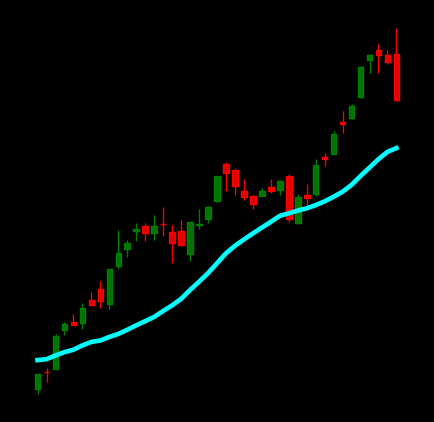

In [8]:
draw_candle_image(
    add_days_around_date("2024-01-05", stock_df, 10, 30), 
    show_x_y=False, 
    show_volume=False, 
    
    **indicator,
    
    figscale=1, 
    figcolor="black", 
    preview_image=True,
    return_image_tensor=False
)

In [9]:
stock_df

,Date,Close,Open,High,Low,Volume,Macd,Macd_signal,Macd_histogram,BB_avg,BB_high,BB_low,SMA,EMA_50,EMA_200
0,2000-07-28 00:00:00+00:00,100.00,100.00,100.00,100.00,4200,0.000000,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2000-07-31 00:00:00+00:00,101.55,101.55,101.55,101.55,10300,0.123647,0.024729,0.098917,100.775000,102.325000,99.225000,100.775000,100.060784,100.015423
2,2000-08-02 00:00:00+00:00,103.38,103.38,103.38,103.38,300,0.365095,0.092802,0.272292,101.643333,104.406246,98.880420,101.643333,100.190950,100.048901
3,2000-08-04 00:00:00+00:00,105.20,105.20,105.20,105.20,3800,0.695288,0.213300,0.481988,102.532500,106.432843,98.632157,102.532500,100.387383,100.100156
4,2000-08-07 00:00:00+00:00,106.92,106.92,106.92,106.92,13200,1.083271,0.387294,0.695977,103.410000,108.358761,98.461239,103.410000,100.643564,100.168015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2024-11-08 00:00:00+00:00,1252.56,1262.84,1264.09,1250.77,503244952,-5.682702,-4.660673,-1.022029,1265.409000,1291.954761,1238.863239,1265.409000,1266.023131,1243.286288
5903,2024-11-11 00:00:00+00:00,1250.32,1253.81,1253.87,1241.29,712083666,-5.907583,-4.910055,-0.997528,1263.608000,1289.095590,1238.120410,1263.608000,1265.407322,1243.356275
5904,2024-11-12 00:00:00+00:00,1244.82,1251.79,1257.02,1242.91,516346103,-6.455196,-5.219084,-1.236112,1261.795000,1287.211786,1236.378214,1261.795000,1264.599976,1243.370839
5905,2024-11-13 00:00:00+00:00,1246.04,1242.94,1247.04,1234.62,587703568,-6.713352,-5.517937,-1.195414,1260.123000,1285.061381,1235.184619,1260.123000,1263.872134,1243.397398


In [10]:
os.environ["JAVA_HOME"] = r'C:\Program Files\Java\jre-1.8'
os.environ["PYSPARK_PYTHON"] = "python" 
spark: SparkSession = SparkSession.builder.master("local").getOrCreate()

In [11]:
data_df_spark = spark.createDataFrame(stock_df)
data_stock = "data_stock"
data_df_spark.createOrReplaceTempView(data_stock)

In [12]:
data_stock_sub_1 = "data_stock_sub_1"
data_stock_include_previous_date = "data_stock_include_previous_date"
bullish_engulfing = "bullish_engulfing"
data_stock_sub_2 = "data_stock_sub_2"
data_stock_sub_3 = "data_stock_sub_3"
bearish_engulfing = "bearish_engulfing"
data_stock_sub_4 = "data_stock_sub_4"
data_stock_include_past_and_future_date = "data_stock_include_past_and_future_date"
data_stock_include_engulfing = "data_stock_include_engulfing"
days_start_engulfing = "days_start_engulfing"
data_stock_day_bearish_engulfing = "data_stock_day_bearish_engulfing"
data_stock_include_group_engulfing = "data_stock_include_group_engulfing"
data_stock_include_group_engulfing_sub_1 = "data_stock_include_group_engulfing_sub_1"
start_and_end_date_of_group_engulfing = "start_and_end_date_of_group_engulfing"
data_stock_include_harami = "data_stock_include_harami"
data_stock_include_tweezer = "data_stock_include_tweezer"
data_stock_include_morning_and_evening_star = "data_stock_include_morning_and_evening_star"
data_stock_include_next_3_day = "data_stock_include_next_3_day"
data_stock_base = "data_stock_base"

Date = "Date"
Close = "Close"
Open = "Open"
High = "High"
Low = "Low"
Macd = "Macd"
Macd_signal = "Macd_signal"
Macd_histogram = "Macd_histogram"

Date_normalized = "Date_normalized"
Body_height = "Body_height"
Max_body_height_in_one_month_around = "Max_body_height_in_one_month_around"
Max_of_candle_body = "Max_of_candle_body"
Min_of_candle_body = "Min_of_candle_body"
Is_star_doji_candle = "Is_star_doji_candle"
Is_candle_up = "Is_candle_up"
Is_narrow_body_candle = "Is_narrow_body_candle"
Is_dragonfly_doji_candle = "Is_dragonfly_doji_candle"
Is_gravestone_doji_candle = "Is_gravestone_doji_candle"

Previous_date = "Previous_date"
Close_of_previous_day = "Close_of_previous_day"
Open_of_previous_day = "Open_of_previous_day"
High_of_previous_day = "High_of_previous_day"
Low_of_previous_day = "Low_of_previous_day"
Is_previous_day_candle_up = "Is_previous_day_candle_up"
Body_height_of_previous_day = "Body_height_of_previous_day"
Is_previous_day_start_doji_candle = "Is_previous_day_start_doji_candle"
Max_of_candle_body_of_previous_day = "Max_of_candle_body_of_previous_day"
Min_of_candle_body_of_previous_day = "Min_of_candle_body_of_previous_day"

Next_date = "Next_date"
Close_of_next_day = "Close_of_next_day"
Open_of_next_day = "Open_of_next_day"
High_of_next_day = "High_of_next_day"
Low_of_next_day = "Low_of_next_day"
Is_next_day_candle_up = "Is_next_day_candle_up"
Is_next_day_start_doji_candle = "Is_next_day_start_doji_candle"
Body_height_of_next_day = "Body_height_of_next_day"
Max_of_candle_body_of_next_day = "Max_of_candle_body_of_next_day"
Min_of_candle_body_of_next_day = "Min_of_candle_body_of_next_day"

Is_start_bullish_engulfing_candle = "Is_start_bullish_engulfing_candle"
Is_start_bearish_engulfing_candle = "Is_start_bearish_engulfing_candle"
Is_recent_candle_is_bullish_engulfing = "Is_recent_candle_is_bullish_engulfing"
Is_recent_candle_is_bearish_engulfing = "Is_recent_candle_is_bearish_engulfing"

Group_id_engulfing = "Group_id_engulfing"
Start_date_of_group = "Start_date_of_group"
End_date_of_group = "End_date_of_group"
Number_days_in_group = "Number_days_in_group"
Group_type = "Group_type"
Start_candle_type = "Start_candle_type"

GROUP_BULL = "GROUP_BULL"
GROUP_BEAR = "GROUP_BEAR"


Is_start_harami_up_candle = "Is_start_harami_up_candle"
Is_start_harami_down_candle = "Is_start_harami_down_candle"

Is_start_tweezer_top_candle = "Is_start_tweezer_top_candle"
Is_start_tweezer_bottom_candle = "Is_start_tweezer_bottom_candle"

Is_marubozu_candle = "Is_marubozu_candle"

Next_2_date = "Next_2_date"
Close_of_next_2_day = "Close_of_next_2_day"
Open_of_next_2_day = "Open_of_next_2_day"
High_of_next_2_day = "High_of_next_2_day"
Low_of_next_2_day = "Low_of_next_2_day"
Is_next_2_day_candle_up = "Is_next_2_day_candle_up"
Is_next_2_day_start_doji_candle = "Is_next_2_day_start_doji_candle"
Body_height_of_next_2_day = "Body_height_of_next_2_day"
Max_of_candle_body_of_next_2_day = "Max_of_candle_body_of_next_2_day"
Min_of_candle_body_of_next_2_day = "Min_of_candle_body_of_next_2_day"


Is_start_morning_star_candle = "Is_start_morning_star_candle"
Is_start_evening_star_candle = "Is_start_evening_star_candle"

Is_hammer_candle = "Is_hammer_candle"
Is_inverted_hammer_candle = "Is_inverted_hammer_candle"

Is_spin_candle = "Is_spin_candle"

Is_start_next_3_day_up_candle = "Is_start_next_3_day_up_candle"
Is_start_next_3_day_down_candle = "Is_start_next_3_day_down_candle"

Total_records = "Total_records"



In [13]:
base_query = f"""
    WITH
    {data_stock_sub_1} AS (
        SELECT
            *,
            CASE
                WHEN 
                    {Is_narrow_body_candle} 
                    AND ABS({High} - {Max_of_candle_body}) / ABS({Low} - {Min_of_candle_body}) * 100 BETWEEN 90 AND 110 
                THEN True
                ELSE False
            END AS {Is_star_doji_candle},
            CASE
                WHEN
                    {Is_narrow_body_candle} 
                    AND ABS({High} - {Max_of_candle_body}) / ABS({Low} - {Min_of_candle_body}) * 100 <= 10
                THEN True
                ELSE False
            END AS {Is_dragonfly_doji_candle},
            CASE
                WHEN
                    {Is_narrow_body_candle} 
                    AND ABS({Low} - {Min_of_candle_body}) / ABS({High} - {Max_of_candle_body}) * 100 <= 10
                THEN True
                ELSE False
            END AS {Is_gravestone_doji_candle},
            CASE
                WHEN
                    ABS({High} - {Max_of_candle_body}) / {Body_height} * 100 <= 2
                    AND ABS({Low} - {Min_of_candle_body}) / {Body_height} * 100 <= 2
                THEN True
                ELSE False
            END AS {Is_marubozu_candle},
            CASE
                WHEN 
                    ABS({Low} - {Min_of_candle_body}) / {Body_height} >= 2
                    AND ABS({High} - {Max_of_candle_body}) / {Body_height} * 100 <= 2
                THEN True
                ELSE False
            END AS {Is_hammer_candle},
            CASE
                WHEN 
                    ABS({High} - {Max_of_candle_body}) / {Body_height} >= 2
                    AND ABS({Low} - {Min_of_candle_body}) / {Body_height} * 100 <= 2
                THEN True
                ELSE False
            END AS {Is_inverted_hammer_candle},
            CASE
                WHEN 
                    {Body_height} / {Max_body_height_in_one_month_around} * 100 <= 20
                    AND ABS({High} - {Max_of_candle_body}) / ABS({Low} - {Min_of_candle_body}) * 100 BETWEEN 90 AND 110 
                THEN True
                ELSE False
            END AS {Is_spin_candle}
        FROM (
            SELECT
                *,
                CASE
                    WHEN
                        {Body_height} / {Max_body_height_in_one_month_around} * 100 <= 2 THEN True
                    ELSE False
                END AS {Is_narrow_body_candle}
            FROM (
                SELECT
                    *,
                    MAX({Body_height}) OVER(ORDER BY {Date_normalized} ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING) AS {Max_body_height_in_one_month_around}
                FROM (
                    SELECT
                        TO_DATE(CAST({Date} AS TIMESTAMP)) AS {Date_normalized},
                        {Close},
                        {Open},
                        {High},
                        {Low},
                        {Macd},
                        {Macd_signal},
                        {Macd_histogram},
                        CASE
                            WHEN {Close} < {Open} THEN False
                            ELSE True
                        END AS {Is_candle_up},
                        GREATEST({Open}, {Close}) AS {Max_of_candle_body},
                        LEAST({Open}, {Close}) AS {Min_of_candle_body},
                        ABS({Open} - {Close}) AS {Body_height}
                    FROM {data_stock}
                    ORDER BY {Date}
                ) AS {data_stock_sub_2}
            ) AS {data_stock_sub_3}
        ) AS {data_stock_sub_4}
    )
    ,
    {data_stock_include_past_and_future_date} AS (
        SELECT
            *,
            LAG({Date_normalized}, 1, {Date_normalized}) OVER(ORDER BY {Date_normalized}) AS {Previous_date},
            LAG({Close}, 1, 0) OVER(ORDER BY {Date_normalized}) AS {Close_of_previous_day},
            LAG({Open}, 1, 0) OVER(ORDER BY {Date_normalized}) AS {Open_of_previous_day},
            LAG({High}, 1, 0) OVER(ORDER BY {Date_normalized}) AS {High_of_previous_day},
            LAG({Low}, 1, 0) OVER(ORDER BY {Date_normalized}) AS {Low_of_previous_day},
            LAG({Is_candle_up}) OVER(ORDER BY {Date_normalized}) AS {Is_previous_day_candle_up},
            LAG({Is_star_doji_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_previous_day_start_doji_candle},
            LAG({Body_height}) OVER(ORDER BY {Date_normalized}) AS {Body_height_of_previous_day},
            LAG({Max_of_candle_body}) OVER(ORDER BY {Date_normalized}) AS {Max_of_candle_body_of_previous_day},
            LAG({Min_of_candle_body}) OVER(ORDER BY {Date_normalized}) AS {Min_of_candle_body_of_previous_day},
            
            LEAD({Date_normalized}) OVER(ORDER BY {Date_normalized}) AS {Next_date},
            LEAD({Close}) OVER(ORDER BY {Date_normalized}) AS {Close_of_next_day},
            LEAD({Open}) OVER(ORDER BY {Date_normalized}) AS {Open_of_next_day},
            LEAD({High}) OVER(ORDER BY {Date_normalized}) AS {High_of_next_day},
            LEAD({Low}) OVER(ORDER BY {Date_normalized}) AS {Low_of_next_day},
            LEAD({Is_candle_up}) OVER(ORDER BY {Date_normalized}) AS {Is_next_day_candle_up},
            LEAD({Is_star_doji_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_next_day_start_doji_candle},
            LEAD({Body_height}) OVER(ORDER BY {Date_normalized}) AS {Body_height_of_next_day},
            LEAD({Max_of_candle_body}) OVER(ORDER BY {Date_normalized}) AS {Max_of_candle_body_of_next_day},
            LEAD({Min_of_candle_body}) OVER(ORDER BY {Date_normalized}) AS {Min_of_candle_body_of_next_day},

            LEAD({Date_normalized}, 2) OVER(ORDER BY {Date_normalized}) AS {Next_2_date},
            LEAD({Close}, 2) OVER(ORDER BY {Date_normalized}) AS {Close_of_next_2_day},
            LEAD({Open}, 2) OVER(ORDER BY {Date_normalized}) AS {Open_of_next_2_day},
            LEAD({High}, 2) OVER(ORDER BY {Date_normalized}) AS {High_of_next_2_day},
            LEAD({Low}, 2) OVER(ORDER BY {Date_normalized}) AS {Low_of_next_2_day},
            LEAD({Is_candle_up}, 2) OVER(ORDER BY {Date_normalized}) AS {Is_next_2_day_candle_up},
            LEAD({Is_star_doji_candle}, 2) OVER(ORDER BY {Date_normalized}) AS {Is_next_2_day_start_doji_candle},
            LEAD({Body_height}, 2) OVER(ORDER BY {Date_normalized}) AS {Body_height_of_next_2_day},
            LEAD({Max_of_candle_body}, 2) OVER(ORDER BY {Date_normalized}) AS {Max_of_candle_body_of_next_2_day},
            LEAD({Min_of_candle_body}, 2) OVER(ORDER BY {Date_normalized}) AS {Min_of_candle_body_of_next_2_day}
        FROM {data_stock_sub_1}
    )
    ,
    {data_stock_include_engulfing} AS (
        SELECT
            *,
            CASE
                WHEN 
                    NOT {Is_candle_up} 
                    AND {Is_next_day_candle_up} 
                    AND {Max_of_candle_body} < {Max_of_candle_body_of_next_day} 
                    AND ABS({Min_of_candle_body} - {Min_of_candle_body_of_next_day}) / {Body_height_of_next_day} * 100  <= 10 
                    -- AND {Body_height} <= {Body_height_of_next_day} / 2 -- Temporary not use this condition
                THEN True
                ELSE False
            END AS {Is_start_bullish_engulfing_candle},
            CASE
                WHEN
                    {Is_candle_up} 
                    AND NOT {Is_next_day_candle_up} 
                    AND {Min_of_candle_body} > {Min_of_candle_body_of_next_day} 
                    AND ABS({Max_of_candle_body} - {Max_of_candle_body_of_next_day}) / {Body_height_of_next_day} * 100  <= 10 
                    -- AND {Body_height} <= {Body_height_of_next_day} / 2 -- Temporary not use this condition
                THEN True
                ELSE False
            END AS {Is_start_bearish_engulfing_candle}
        FROM {data_stock_include_past_and_future_date}
    )
    ,
    {days_start_engulfing} AS (
        SELECT
            {Date_normalized},
            LAG({Is_start_bullish_engulfing_candle}, 1, {Is_start_bullish_engulfing_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_recent_candle_is_bullish_engulfing},
            LAG({Is_start_bearish_engulfing_candle}, 1, {Is_start_bearish_engulfing_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_recent_candle_is_bearish_engulfing}
        FROM {data_stock_include_engulfing}
        WHERE {Is_start_bullish_engulfing_candle} OR {Is_start_bearish_engulfing_candle}
    )
    ,
    {data_stock_include_group_engulfing} AS (
        SELECT
            *,
            MAX({Start_candle_type}) OVER(PARTITION BY {Group_id_engulfing}) AS {Group_type}
        FROM (
            SELECT
                {data_stock_include_engulfing}.*,
                SUM(
                    CASE
                        WHEN {Is_start_bullish_engulfing_candle} AND {Is_recent_candle_is_bearish_engulfing} THEN 1
                        WHEN {Is_start_bearish_engulfing_candle} AND {Is_recent_candle_is_bullish_engulfing} THEN 1
                        ELSE 0
                    END
                ) OVER(ORDER BY {data_stock_include_engulfing}.{Date_normalized}) AS {Group_id_engulfing},
                CASE
                    WHEN {Is_start_bullish_engulfing_candle} THEN "{GROUP_BULL}"
                    WHEN {Is_start_bearish_engulfing_candle} THEN "{GROUP_BEAR}"
                    ELSE ""
                END AS {Start_candle_type}
            FROM {data_stock_include_engulfing} 
            LEFT JOIN {days_start_engulfing}
                ON {days_start_engulfing}.{Date_normalized} = {data_stock_include_engulfing}.{Date_normalized}
        ) AS {data_stock_include_group_engulfing_sub_1}
    )
    ,
    {start_and_end_date_of_group_engulfing} AS (
        SELECT
            {Group_id_engulfing},
            {Group_type},
            MIN({data_stock_include_group_engulfing}.{Date_normalized}) AS {Start_date_of_group},
            MAX({data_stock_include_group_engulfing}.{Date_normalized}) AS {End_date_of_group},
            COUNT(*) AS {Number_days_in_group}
        FROM {data_stock_include_group_engulfing} 
        GROUP BY {Group_id_engulfing}, {Group_type}
    )
    ,
    {data_stock_include_harami} AS (
        SELECT
            *,
            CASE
                WHEN 
                    NOT {Is_candle_up} 
                    AND {Is_next_day_candle_up} 
                    AND {Max_of_candle_body} > {Max_of_candle_body_of_next_day} 
                    AND ABS({Min_of_candle_body} - {Min_of_candle_body_of_next_day}) / {Body_height} * 100  <= 10 
                    AND {Body_height} > {Body_height_of_next_day}
                THEN True
                ELSE False
            END AS {Is_start_harami_up_candle},
            CASE
                WHEN
                    {Is_candle_up} 
                    AND NOT {Is_next_day_candle_up} 
                    AND {Min_of_candle_body} < {Min_of_candle_body_of_next_day} 
                    AND ABS({Max_of_candle_body} - {Max_of_candle_body_of_next_day}) / {Body_height} * 100  <= 10 
                    AND {Body_height} > {Body_height_of_next_day}
                THEN True
                ELSE False
            END AS {Is_start_harami_down_candle}
        FROM {data_stock_include_group_engulfing}
    )
    ,
    {data_stock_include_tweezer} AS (
        SELECT
            *,
            CASE 
                WHEN 
                    {Is_candle_up}
                    AND NOT {Is_next_day_candle_up}
                    AND {Body_height} / {Body_height_of_next_day} * 100 BETWEEN 90 AND 110
                THEN True
                ELSE False
            END AS {Is_start_tweezer_top_candle},
            CASE 
                WHEN 
                    NOT {Is_candle_up}
                    AND {Is_next_day_candle_up}
                    AND {Body_height} / {Body_height_of_next_day} * 100 BETWEEN 90 AND 110
                THEN True
                ELSE False
            END AS {Is_start_tweezer_bottom_candle}
            
        FROM {data_stock_include_harami}
    )
    ,
    {data_stock_include_morning_and_evening_star} AS (
        SELECT
            *,
            CASE
                WHEN
                    NOT {Is_candle_up}
                    AND {Is_next_2_day_candle_up}
                    AND {Body_height_of_next_day} / {Body_height} * 100 <= 20
                    AND {Body_height_of_next_day} / {Body_height_of_next_2_day} * 100 <= 20
                THEN True
                ELSE False
            END AS {Is_start_morning_star_candle},
            CASE
                WHEN
                    {Is_candle_up}
                    AND NOT {Is_next_2_day_candle_up}
                    AND {Body_height_of_next_day} / {Body_height} * 100 <= 20
                    AND {Body_height_of_next_day} / {Body_height_of_next_2_day} * 100 <= 20
                THEN True
                ELSE False
            END AS {Is_start_evening_star_candle}
        FROM {data_stock_include_tweezer}
    )
    ,
    {data_stock_include_next_3_day} AS (
        SELECT
            *,
            CASE
                WHEN 
                    {Is_candle_up}
                    AND {Is_next_day_candle_up}
                    AND {Is_next_2_day_candle_up}
                THEN True
                ELSE False
            END AS {Is_start_next_3_day_up_candle},
            CASE
                WHEN 
                    NOT {Is_candle_up}
                    AND NOT {Is_next_day_candle_up}
                    AND NOT {Is_next_2_day_candle_up}
                THEN True
                ELSE False
            END AS {Is_start_next_3_day_down_candle}
        FROM {data_stock_include_morning_and_evening_star}
    )
    ,
    {data_stock_base} AS (
        SELECT
            *
        FROM {data_stock_include_next_3_day}
    )
    
"""

In [14]:
def random_month_test_in_year(total_years, years_to_test):
    month_test_in_year = dict()
    for year in total_years:
        if year in years_to_test:
            number_month = years_to_test[year]
            month_test_in_year[year] = []
            for _ in range(number_month):
                if year == 2014:
                    month_test = random.randint(9, 12)
                elif year == 2024:
                    month_test = random.randint(1, 11)
                else:
                    month_test = random.randint(1, 12)
                    
                month_test_in_year[year].append(month_test)
        else:
            month_test_in_year[year] = [0]
    return month_test_in_year

In [15]:
month_test_in_year = random_month_test_in_year(
    years, 
    years_to_test
)

In [16]:
month_test_in_year

{2014: [0],
 2015: [0],
 2016: [0],
 2017: [0],
 2018: [0],
 2019: [0],
 2020: [0],
 2021: [0],
 2022: [2],
 2023: [6, 8, 10],
 2024: [8, 2, 11]}

In [17]:
def generate_exclude_month_query_for_train(year_and_months):
    list_query = []
    for year in year_and_months:
        months = year_and_months[year]
        list_query_of_year = []
        for m in months:
            q = f"(YEAR({Date_normalized}) = {year} AND MONTH({Date_normalized}) != {m})"
            list_query_of_year.append(q)
        query_of_year = " AND ".join(list_query_of_year)
        list_query.append(f"({query_of_year})")
    return " OR ".join(list_query)

In [18]:
def generate_include_month_query_for_test(year_and_months):
    list_query = []
    for year in year_and_months:
        months = year_and_months[year]
        list_query_of_year = []
        for m in months:
            q = f"(YEAR({Date_normalized}) = {year} AND MONTH({Date_normalized}) = {m})"
            list_query_of_year.append(q)
        query_of_year = " OR ".join(list_query_of_year)
        list_query.append(f"({query_of_year})")
    return " OR ".join(list_query)

In [19]:
generate_exclude_month_query_for_train(month_test_in_year)

'((YEAR(Date_normalized) = 2014 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2015 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2016 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2017 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2018 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2019 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2020 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2021 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2022 AND MONTH(Date_normalized) != 2)) OR ((YEAR(Date_normalized) = 2023 AND MONTH(Date_normalized) != 6) AND (YEAR(Date_normalized) = 2023 AND MONTH(Date_normalized) != 8) AND (YEAR(Date_normalized) = 2023 AND MONTH(Date_normalized) != 10)) OR ((YEAR(Date_normalized) = 2024 AND MONTH(Date_normalized) != 8) AND (YEAR(Date_normalized) = 2024 AND MONTH(Date_normalized) != 2) AND (YEAR(Date_normalized) = 2024 AND MONTH(Date_norm

In [20]:
generate_include_month_query_for_test(month_test_in_year)

'((YEAR(Date_normalized) = 2014 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2015 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2016 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2017 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2018 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2019 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2020 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2021 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2022 AND MONTH(Date_normalized) = 2)) OR ((YEAR(Date_normalized) = 2023 AND MONTH(Date_normalized) = 6) OR (YEAR(Date_normalized) = 2023 AND MONTH(Date_normalized) = 8) OR (YEAR(Date_normalized) = 2023 AND MONTH(Date_normalized) = 10)) OR ((YEAR(Date_normalized) = 2024 AND MONTH(Date_normalized) = 8) OR (YEAR(Date_normalized) = 2024 AND MONTH(Date_normalized) = 2) OR (YEAR(Date_normalized) = 2024 AND MONTH(Date_normalized) = 11))'

In [21]:
def save_to_tensorflow_dataset(
    df_date: pd.DataFrame, 
    df_original: pd.DataFrame, 
    previous_days: int, 
    next_days: int,
    days_result: int,
    figscale: int,
    number_images_preview = 0,
    save_dataset_to_folder = None,
    number_images_to_save = None,
    indicator = {},
    ):
    
    total_days = previous_days + 1 + next_days + days_result
    if len(df_date) < total_days:
        return
    
    count = 0
    total_images = df_date[Total_records][0]
    print(f"Total: {total_images} images")
    
    df_original = convert_number_index(df_original)
    
    list_images = []
    list_targets = []
    
    random_image_index_show = np.random.randint(0, total_images, size=number_images_preview)
    for date in df_date[Date_normalized]:
        count += 1
        if count % 100 == 0:
            print(f"Load {count}/{total_images} images")
            
        if number_images_to_save is not None and count > number_images_to_save:
            break
        
        draw_df_pandas = add_days_around_date(date, df_original, previous_days, next_days)
        if len(draw_df_pandas) < (previous_days + next_days):
            continue
        
        is_preview_image = count in random_image_index_show
        image_tensor = draw_candle_image(
            draw_df_pandas, 
            show_x_y=False, 
            show_volume=False, 
            
            **indicator,
            
            figscale=figscale, 
            figcolor="black", 
            preview_image=is_preview_image,
            return_image_tensor=True
        )
        
        image_tensor = normalize_candle_image(
            image_tensor, 
            combine_into_one_image=False,
            convert_red=False,
            convert_green=False,
        )
        
        date = normalize_date(date)
        index_of_date = get_date_index(df_original, date)
        start_index = index_of_date - previous_days
        end_index = index_of_date + next_days + days_result
        data_result_df = df_original[start_index:end_index + 1]
    
        if 0 < len(data_result_df) < total_days:
            data_result_df = duplicate_last_row(data_result_df, total_days - len(data_result_df))
        elif len(data_result_df) == 0:
            continue
        
        last_close_price = draw_df_pandas.iloc[-1][Close]
        targets = data_result_df[[High, Open, Close, Low]].to_numpy()
        # targets = ((targets - last_close_price) / last_close_price) * 100
        
        list_images.append(image_tensor)
        list_targets.append(targets)
        
            
    list_images = np.array(list_images)
    list_targets = np.array(list_targets)
    
    print(f"list_images shape = {list_images.shape}")
    print(f"list_targets shape = {list_targets.shape}")
    
    dataset = tf.data.Dataset.from_tensor_slices((list_images, list_targets))
    
    if save_dataset_to_folder is not None:
        if not os.path.exists(save_dataset_to_folder):
            os.makedirs(save_dataset_to_folder)
        else:
            exist_ok = input(f"Folder {save_dataset_to_folder} already exists, continue? [y/n]: ").lower() == "y"
            if not exist_ok:
                return dataset
    
        tf.data.Dataset.save(dataset, save_dataset_to_folder)
    
    return dataset

Total: 131 images
Load 100/131 images
list_images shape = (130, 287, 287, 3)
list_targets shape = (130, 18, 4)


<_TensorSliceDataset element_spec=(TensorSpec(shape=(287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(18, 4), dtype=tf.float64, name=None))>

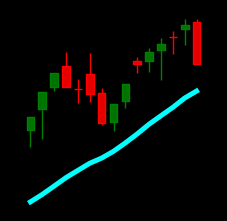

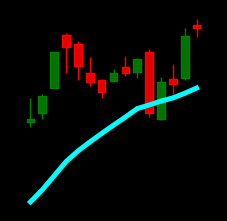

In [22]:
test_query = f"""
    {base_query}
    
    SELECT
        COUNT(*) OVER() AS {Total_records},
        *
    FROM {data_stock_base}
    WHERE ({generate_include_month_query_for_test(month_test_in_year)})
"""

test_df_spark = spark.sql(test_query)
# test_df_spark.show(10)
save_to_tensorflow_dataset(
    test_df_spark.toPandas(),
    stock_df,
    previous_days=previous_days,
    next_days=next_days,
    days_result=days_result,
    number_images_preview=2,
    save_dataset_to_folder=f"{folder_save}/test",
    figscale=figscale,
    indicator=indicator
)

In [23]:
candle_type = [
    Is_start_bullish_engulfing_candle,
    Is_start_bearish_engulfing_candle,
    Is_star_doji_candle,
    Is_dragonfly_doji_candle,
    Is_gravestone_doji_candle,
    Is_start_morning_star_candle,
    Is_start_evening_star_candle,
    Is_hammer_candle,
    Is_inverted_hammer_candle,
    Is_start_harami_down_candle,
    Is_start_harami_up_candle,
    Is_start_tweezer_top_candle,
    Is_start_tweezer_bottom_candle,
    Is_marubozu_candle,
    Is_spin_candle,
    Is_start_next_3_day_up_candle,
    Is_start_next_3_day_down_candle
]

In [24]:
candle_type

['Is_start_bullish_engulfing_candle',
 'Is_start_bearish_engulfing_candle',
 'Is_star_doji_candle',
 'Is_dragonfly_doji_candle',
 'Is_gravestone_doji_candle',
 'Is_start_morning_star_candle',
 'Is_start_evening_star_candle',
 'Is_hammer_candle',
 'Is_inverted_hammer_candle',
 'Is_start_harami_down_candle',
 'Is_start_harami_up_candle',
 'Is_start_tweezer_top_candle',
 'Is_start_tweezer_bottom_candle',
 'Is_marubozu_candle',
 'Is_spin_candle',
 'Is_start_next_3_day_up_candle',
 'Is_start_next_3_day_down_candle']

In [25]:
candle_type_and_directory_save = {
    Is_start_bullish_engulfing_candle: "bullish_engulfing",
    Is_start_bearish_engulfing_candle: "bearish_engulfing",
    Is_star_doji_candle: "star_doji",
    Is_dragonfly_doji_candle: "dragonfly_doji",
    Is_gravestone_doji_candle: "gravestone_doji",
    Is_start_morning_star_candle: "morning_star",
    Is_start_evening_star_candle: "evening_star",
    Is_hammer_candle: "hammer",
    Is_inverted_hammer_candle: "inverted_hammer",
    Is_start_harami_down_candle: "harami_down",
    Is_start_harami_up_candle: "harami_up",
    Is_start_tweezer_top_candle: "tweezer_top",
    Is_start_tweezer_bottom_candle: "tweezer_bottom",
    Is_marubozu_candle: "marubozu",
    Is_spin_candle: "spin",
    Is_start_next_3_day_up_candle: "next_3_day_up",
    Is_start_next_3_day_down_candle: "next_3_day_down",
}

In [26]:
candle_type_and_directory_save

{'Is_start_bullish_engulfing_candle': 'bullish_engulfing',
 'Is_start_bearish_engulfing_candle': 'bearish_engulfing',
 'Is_star_doji_candle': 'star_doji',
 'Is_dragonfly_doji_candle': 'dragonfly_doji',
 'Is_gravestone_doji_candle': 'gravestone_doji',
 'Is_start_morning_star_candle': 'morning_star',
 'Is_start_evening_star_candle': 'evening_star',
 'Is_hammer_candle': 'hammer',
 'Is_inverted_hammer_candle': 'inverted_hammer',
 'Is_start_harami_down_candle': 'harami_down',
 'Is_start_harami_up_candle': 'harami_up',
 'Is_start_tweezer_top_candle': 'tweezer_top',
 'Is_start_tweezer_bottom_candle': 'tweezer_bottom',
 'Is_marubozu_candle': 'marubozu',
 'Is_spin_candle': 'spin',
 'Is_start_next_3_day_up_candle': 'next_3_day_up',
 'Is_start_next_3_day_down_candle': 'next_3_day_down'}

In [27]:
for candle_type, directory_save in candle_type_and_directory_save.items():
    print(f"{candle_type=}")
    print(f"{directory_save=}")
    
    query = f"""
        {base_query}
        
        SELECT
            COUNT(*) OVER() AS {Total_records},
            *
        FROM {data_stock_base}
        WHERE {candle_type}
        AND ({generate_exclude_month_query_for_train(month_test_in_year)})
    """
    
    df_spark = spark.sql(query)
    save_to_tensorflow_dataset(
        df_spark.toPandas(),
        stock_df,
        previous_days=previous_days,
        next_days=next_days,
        days_result=days_result,
        number_images_preview=0,
        save_dataset_to_folder=f"{folder_save}/{directory_save}",
        figscale=figscale,
        indicator=indicator
    )



candle_type='Is_start_bullish_engulfing_candle'
directory_save='bullish_engulfing'
Total: 88 images
list_images shape = (88, 287, 287, 3)
list_targets shape = (88, 18, 4)
candle_type='Is_start_bearish_engulfing_candle'
directory_save='bearish_engulfing'
Total: 79 images
list_images shape = (79, 287, 287, 3)
list_targets shape = (79, 18, 4)
candle_type='Is_star_doji_candle'
directory_save='star_doji'
candle_type='Is_dragonfly_doji_candle'
directory_save='dragonfly_doji'
candle_type='Is_gravestone_doji_candle'
directory_save='gravestone_doji'
candle_type='Is_start_morning_star_candle'
directory_save='morning_star'
Total: 24 images
list_images shape = (24, 287, 287, 3)
list_targets shape = (24, 18, 4)
candle_type='Is_start_evening_star_candle'
directory_save='evening_star'
Total: 50 images
list_images shape = (50, 287, 287, 3)
list_targets shape = (50, 18, 4)
candle_type='Is_hammer_candle'
directory_save='hammer'
Total: 31 images
list_images shape = (31, 287, 287, 3)
list_targets shape = 

In [28]:
month_test_in_year_copy = month_test_in_year
# for key, value in month_test_in_year.items():
#     month_test_in_year_copy[int(key)] = int(value)

In [29]:
config = {
    "month_test_in_year": month_test_in_year_copy,
    "candle_type_and_directory_save": candle_type_and_directory_save,
    "folder_save": folder_save,
    "figscale": figscale,
    "previous_days": previous_days,
    "next_days": next_days,
    "days_result": days_result,
    
    "indicator": indicator
}

In [30]:
config

{'month_test_in_year': {2014: [0],
  2015: [0],
  2016: [0],
  2017: [0],
  2018: [0],
  2019: [0],
  2020: [0],
  2021: [0],
  2022: [2],
  2023: [6, 8, 10],
  2024: [8, 2, 11]},
 'candle_type_and_directory_save': {'Is_start_bullish_engulfing_candle': 'bullish_engulfing',
  'Is_start_bearish_engulfing_candle': 'bearish_engulfing',
  'Is_star_doji_candle': 'star_doji',
  'Is_dragonfly_doji_candle': 'dragonfly_doji',
  'Is_gravestone_doji_candle': 'gravestone_doji',
  'Is_start_morning_star_candle': 'morning_star',
  'Is_start_evening_star_candle': 'evening_star',
  'Is_hammer_candle': 'hammer',
  'Is_inverted_hammer_candle': 'inverted_hammer',
  'Is_start_harami_down_candle': 'harami_down',
  'Is_start_harami_up_candle': 'harami_up',
  'Is_start_tweezer_top_candle': 'tweezer_top',
  'Is_start_tweezer_bottom_candle': 'tweezer_bottom',
  'Is_marubozu_candle': 'marubozu',
  'Is_spin_candle': 'spin',
  'Is_start_next_3_day_up_candle': 'next_3_day_up',
  'Is_start_next_3_day_down_candle': '

In [31]:
with open(f"{folder_save}/config.json", "w") as f:
    json.dump(config, f, indent=4)